# Using CNN to Classify Meat Freshness Images

data from: https://www.kaggle.com/datasets/vinayakshanawad/meat-freshness-image-dataset?resource=download </br>
The business applications for developing a CNN model to classify the freshness of meat samples includes better quality control, consumer satisfaction, and food safety. Meat processing companies can use a CNN model to automate the process of inspecting meat samples for freshness and quality. This can help reduce human error and ensure consistent quality across batches. Retailers and online marketplaces that sell meat can use a similar model to determine the freshness of meat products on their shelves or website quickly and accurately, reducing the risk of selling spoiled products and improving customer satisfaction. Deep learning models can be used to detect spoiled meat early, which can prevent food-borne illnesses and reduce the risk of product recalls. This can help protect the brand reputation of food processing companies and retailers. Overall, developing a CNN model to classify the freshness of meat samples can provide several benefits to businesses operating in the meat processing, retail, and food safety industries.

## Import Python libraries

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization

## The Meat Freshness Image dataset

It includes 2266 images.
Color-Marbling-Freshness are annotated in Multi-Class Classification format.

The following pre-processing was applied to each image:

    Auto-orientation of pixel data (with EXIF-orientation stripping)
    Resize to 416x416 (Stretch)

No image augmentation techniques were applied.

    Train folder contains 1816 images with labels file.
    Validation folder contains 452 images with labels file.


In [2]:
train_path = os.path.join('Meat Freshness.v1-new-dataset.multiclass', 'train')
file_train = os.listdir(train_path)
names = [i.split('-')[0] for i in file_train]
set(names)

{'FRESH', 'HALF', 'SPOILED', '_classes.csv'}

In [3]:
class_names = {'SPOILED': 0, 'HALF': 1, 'FRESH': 2}

In [4]:
train_x, train_y, test_x, test_y, = [], [], [], []

In [5]:
train_path = './Meat Freshness.v1-new-dataset.multiclass/train/'

for file_name in os.listdir(train_path):
    class_name = file_name.split('-')[0]
    if(class_name == '_classes.csv'): continue # ignore the csv file
    img = cv2.imread(train_path+file_name).astype('float32') # read the image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert to rgb format
    img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA) # resize the image
    img /= 255. # normalising pixel values
    train_x.append(img)
    train_y.append(class_names[class_name])

In [6]:
val_path = './Meat Freshness.v1-new-dataset.multiclass/valid/'

for file_name in os.listdir(val_path):
    class_name = file_name.split('-')[0]
    if(class_name == '_classes.csv'): continue # ignore the csv file
    img = cv2.imread(val_path+file_name).astype('float32') # read the colour image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert to rgb format
    img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA) # resize the image
    img /= 255. # normalising pixel values
    test_x.append(img)
    test_y.append(class_names[class_name])

In [7]:
train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)
test_y = np.array(test_y)

In [8]:
print('shape of train_x: {}'.format(train_x.shape))
print('len of train_y: '+ str(len(train_y)))
print('shape of test_x: {}'.format(test_x.shape))
print('len of test y: '+ str(len(test_y)))

shape of train_x: (1815, 128, 128, 3)
len of train_y: 1815
shape of test_x: (451, 128, 128, 3)
len of test y: 451


## Data Visualizations

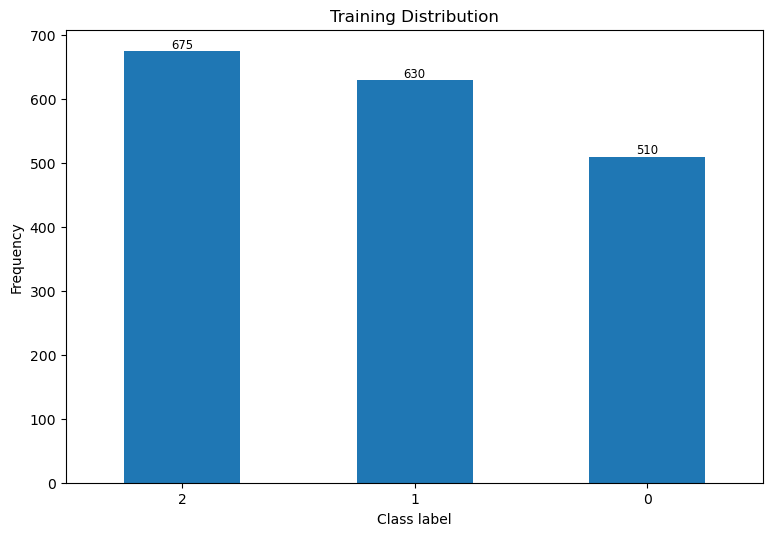

In [9]:
pd.Series(train_y).value_counts().plot(kind='bar', xlabel = 'Class label', ylabel = 'Frequency',
                                        title = 'Training Distribution', figsize = (9, 6), rot = 360)
plt.gcf().set_dpi(100)

temp = pd.Series(train_y).value_counts()
j= 0
for i in temp.index:    
        plt.text(j, temp[i], temp[i],ha = "center", va = "bottom", fontsize = 'small', rotation = 0)
        j = j+1

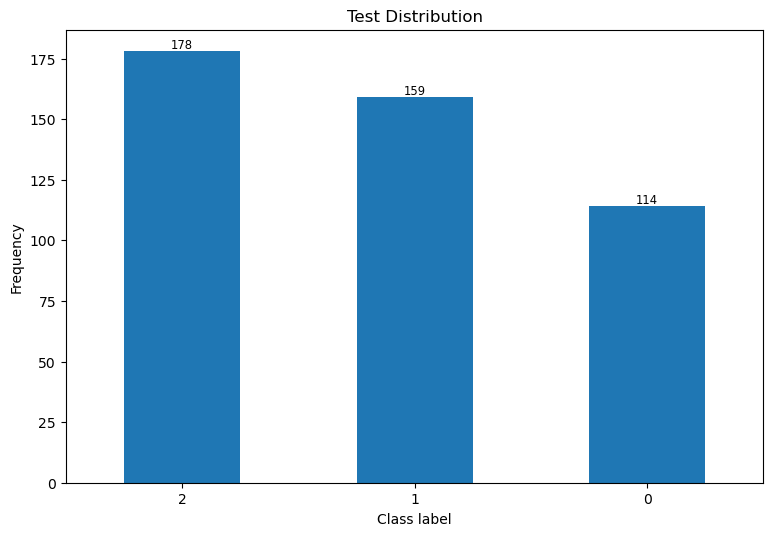

In [10]:
pd.Series(test_y).value_counts().plot(kind='bar', xlabel = 'Class label', ylabel = 'Frequency',
                                        title = 'Test Distribution', figsize = (9, 6), rot = 360)
plt.gcf().set_dpi(100)

temp = pd.Series(test_y).value_counts()
j= 0
for i in temp.index:    
        plt.text(j, temp[i], temp[i],ha = "center", va = "bottom", fontsize = 'small', rotation = 0)
        j = j+1

## Sample Visualizations

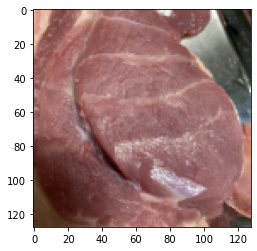

In [11]:
plt.figure()
plt.imshow(train_x[0])
plt.grid(False)
plt.show()

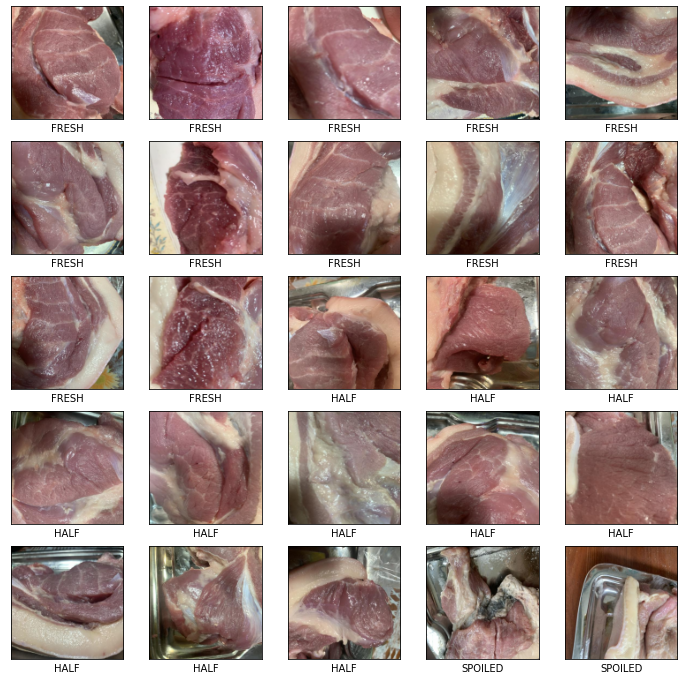

In [12]:
plt.figure(figsize=(12,12))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_x[i*59])
    plt.xlabel(list(class_names.keys())[list(class_names.values()).index(train_y[i*59])])
plt.show()

## Build the models

### Baseline Model

In [13]:
def create_model(): 
    model = Sequential()
    model.add(Flatten(input_shape=(128, 128, 3)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='relu'))
    
    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    return model

model_simple = create_model()
model_simple.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 49152)             0         
                                                                 
 dense (Dense)               (None, 128)               6291584   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
Total params: 6,300,035
Trainable params: 6,300,035
Non-trainable params: 0
_________________________________________________________________


In [14]:
from tensorflow import keras

callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=8,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath="checkpoint_path.keras",
        monitor="val_loss",
        save_best_only=True,
    )
]


dnn_history = model_simple.fit(train_x,  train_y, epochs=100, 
          batch_size=500, validation_split=0.3, 
          callbacks=callbacks_list)

Epoch 1/100
3/3 [==============================] - 1s 231ms/step - loss: 5.2438 - accuracy: 0.3827 - val_loss: 1.0986 - val_accuracy: 0.9358
Epoch 2/100
3/3 [==============================] - 0s 113ms/step - loss: 1.1704 - accuracy: 0.1055 - val_loss: 1.0986 - val_accuracy: 0.9358
Epoch 3/100
3/3 [==============================] - 0s 112ms/step - loss: 1.0986 - accuracy: 0.0000e+00 - val_loss: 1.0986 - val_accuracy: 0.9358
Epoch 4/100
3/3 [==============================] - 0s 126ms/step - loss: 1.0986 - accuracy: 0.0000e+00 - val_loss: 1.0986 - val_accuracy: 0.9358
Epoch 5/100
3/3 [==============================] - 0s 113ms/step - loss: 1.0986 - accuracy: 0.0000e+00 - val_loss: 1.0986 - val_accuracy: 0.9358
Epoch 6/100
3/3 [==============================] - 0s 115ms/step - loss: 1.0986 - accuracy: 0.0000e+00 - val_loss: 1.0986 - val_accuracy: 0.9358
Epoch 7/100
3/3 [==============================] - 0s 126ms/step - loss: 1.0986 - accuracy: 0.0000e+00 - val_loss: 1.0986 - val_accuracy: 

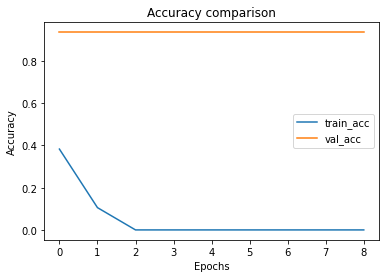

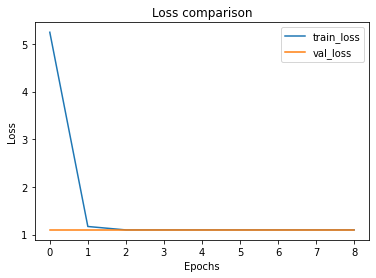

In [32]:
plt.plot(dnn_history.history['accuracy'], label='train_acc')
plt.plot(dnn_history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title('Accuracy comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

plt.plot(dnn_history.history['loss'], label='train_loss')
plt.plot(dnn_history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### Baseline CNN Model

In [16]:
def create_simple_cnn(): 
    model = Sequential()
    model.add(Conv2D(16, 3, activation='relu', input_shape=(128, 128, 3)))
    model.add(MaxPooling2D(2))
    model.add(Conv2D(32, 3, activation='relu'))
    model.add(MaxPooling2D(2))
    model.add(Conv2D(64, 3, activation='relu'))
    model.add(MaxPooling2D(2))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(3, activation='softmax'))

  # compile model
    model.compile(optimizer='adam', 
                loss= 'sparse_categorical_crossentropy',
                metrics=['accuracy'])
    return model

simple_cnn = create_simple_cnn()
simple_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)      

In [17]:
simple_history = simple_cnn.fit(train_x,  train_y, epochs=100, 
          batch_size=500, validation_split=0.3, 
          callbacks=callbacks_list)

Epoch 1/100
3/3 [==============================] - 5s 1s/step - loss: 1.0377 - accuracy: 0.4354 - val_loss: 7.6287 - val_accuracy: 0.0642
Epoch 2/100
3/3 [==============================] - 4s 1s/step - loss: 0.7469 - accuracy: 0.5063 - val_loss: 5.1785 - val_accuracy: 0.0000e+00
Epoch 3/100
3/3 [==============================] - 4s 1s/step - loss: 0.7287 - accuracy: 0.5386 - val_loss: 3.6678 - val_accuracy: 0.0385
Epoch 4/100
3/3 [==============================] - 4s 1s/step - loss: 0.6816 - accuracy: 0.6189 - val_loss: 5.9354 - val_accuracy: 0.0000e+00
Epoch 5/100
3/3 [==============================] - 4s 1s/step - loss: 0.6224 - accuracy: 0.6402 - val_loss: 8.4025 - val_accuracy: 0.0385
Epoch 6/100
3/3 [==============================] - 4s 1s/step - loss: 0.5650 - accuracy: 0.7110 - val_loss: 12.5770 - val_accuracy: 0.0239
Epoch 7/100
3/3 [==============================] - 4s 1s/step - loss: 0.5126 - accuracy: 0.7252 - val_loss: 18.9141 - val_accuracy: 0.0202
Epoch 8/100
3/3 [=======

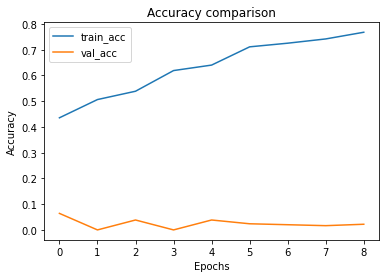

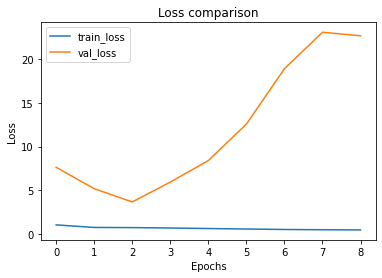

In [33]:
plt.plot(simple_history.history['accuracy'], label='train_acc')
plt.plot(simple_history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title('Accuracy comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

plt.plot(simple_history.history['loss'], label='train_loss')
plt.plot(simple_history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### CNN Model with Dropout

In [19]:
def create_cnn(): 
    model = Sequential()
    model.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(128, 128, 3)))
    model.add(MaxPooling2D())
    model.add.Dropout(0.5)
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D())
    model.add.Dropout(0.5)
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D())
    model.add.Dropout(0.5)
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add.Dropout(0.5)
    model.add(Dense(3, activation='softmax'))

  # compile model
    model.compile(optimizer='adam', 
                loss= 'sparse_categorical_crossentropy',
                metrics=['accuracy'])
    return model

cnn_model1 = create_simple_cnn()
cnn_model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 63, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 64)      

In [20]:
history1 = cnn_model1.fit(train_x,  train_y, epochs=100, 
          batch_size=500, validation_split=0.3, 
          callbacks=callbacks_list)

Epoch 1/100
3/3 [==============================] - 5s 1s/step - loss: 0.9094 - accuracy: 0.3614 - val_loss: 6.5938 - val_accuracy: 0.0000e+00
Epoch 2/100
3/3 [==============================] - 4s 1s/step - loss: 0.7142 - accuracy: 0.5315 - val_loss: 4.8975 - val_accuracy: 0.0000e+00
Epoch 3/100
3/3 [==============================] - 4s 1s/step - loss: 0.6914 - accuracy: 0.5047 - val_loss: 5.1222 - val_accuracy: 0.0532
Epoch 4/100
3/3 [==============================] - 4s 1s/step - loss: 0.6512 - accuracy: 0.6394 - val_loss: 7.7715 - val_accuracy: 0.0055
Epoch 5/100
3/3 [==============================] - 4s 1s/step - loss: 0.5775 - accuracy: 0.7000 - val_loss: 13.8304 - val_accuracy: 0.0183
Epoch 6/100
3/3 [==============================] - 4s 1s/step - loss: 0.5326 - accuracy: 0.7157 - val_loss: 20.0765 - val_accuracy: 0.0275
Epoch 7/100
3/3 [==============================] - 4s 1s/step - loss: 0.5419 - accuracy: 0.7087 - val_loss: 19.0021 - val_accuracy: 0.0147
Epoch 8/100
3/3 [======

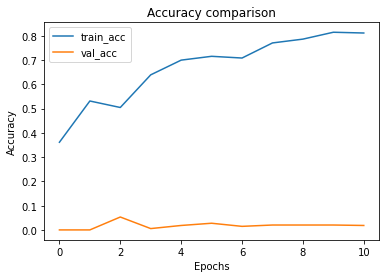

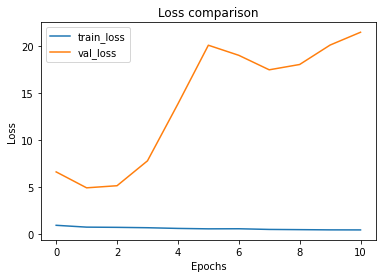

In [36]:
plt.plot(history1.history['accuracy'], label='train_acc')
plt.plot(history1.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title('Accuracy comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

plt.plot(history1.history['loss'], label='train_loss')
plt.plot(history1.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### Image Augmentation

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest', 
      validation_split = 0.3)

In [23]:
aug_history = cnn_model1.fit(datagen.flow(train_x,  train_y, batch_size = 500), 
                                validation_data = datagen.flow(train_x,  train_y, batch_size = 125), 
                                epochs=100, callbacks=callbacks_list)

Epoch 1/100
4/4 [==============================] - 12s 3s/step - loss: 3.5877 - accuracy: 0.4953 - val_loss: 1.0739 - val_accuracy: 0.5008
Epoch 2/100
4/4 [==============================] - 11s 3s/step - loss: 1.0859 - accuracy: 0.3245 - val_loss: 1.0877 - val_accuracy: 0.2832
Epoch 3/100
4/4 [==============================] - 11s 3s/step - loss: 1.0876 - accuracy: 0.3719 - val_loss: 1.0811 - val_accuracy: 0.4826
Epoch 4/100
4/4 [==============================] - 11s 3s/step - loss: 1.0785 - accuracy: 0.4948 - val_loss: 1.0757 - val_accuracy: 0.4705
Epoch 5/100
4/4 [==============================] - 11s 3s/step - loss: 1.0737 - accuracy: 0.4380 - val_loss: 1.0649 - val_accuracy: 0.4209
Epoch 6/100
4/4 [==============================] - 11s 3s/step - loss: 1.0639 - accuracy: 0.4441 - val_loss: 1.0570 - val_accuracy: 0.4050
Epoch 7/100
4/4 [==============================] - 12s 3s/step - loss: 1.0528 - accuracy: 0.4226 - val_loss: 1.0292 - val_accuracy: 0.5212
Epoch 8/100
4/4 [==========

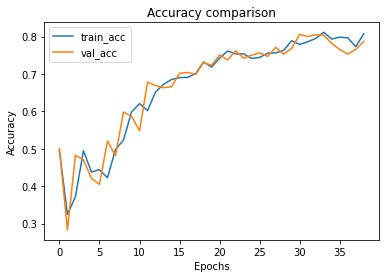

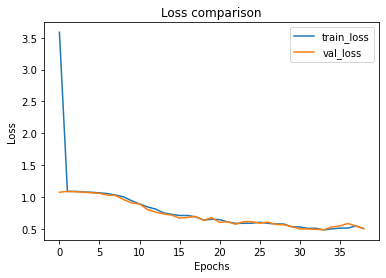

In [34]:
plt.plot(aug_history.history['accuracy'], label='train_acc')
plt.plot(aug_history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title('Accuracy comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

plt.plot(aug_history.history['loss'], label='train_loss')
plt.plot(aug_history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### Model with BatchNormalization

In [25]:
def create_cnn(): 
    model = Sequential()
    model.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(128, 128, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add.Dropout(0.25)
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add.Dropout(0.25)
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add.Dropout(0.25)
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add.Dropout(0.5)
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))

  # compile model
    model.compile(optimizer='adam', 
                loss= 'sparse_categorical_crossentropy',
                metrics=['accuracy'])
    return model

cnn_model2 = create_simple_cnn()
cnn_model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 63, 63, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 64)      

In [27]:
aug_history2 = cnn_model2.fit(datagen.flow(train_x,  train_y, batch_size = 250), 
                                validation_data = datagen.flow(train_x,  train_y, batch_size = 75), 
                                epochs=100, callbacks=callbacks_list)

Epoch 1/100
8/8 [==============================] - 12s 1s/step - loss: 1.3565 - accuracy: 0.3245 - val_loss: 1.1009 - val_accuracy: 0.2810
Epoch 2/100
8/8 [==============================] - 11s 1s/step - loss: 1.0879 - accuracy: 0.3950 - val_loss: 1.0453 - val_accuracy: 0.5361
Epoch 3/100
8/8 [==============================] - 11s 1s/step - loss: 1.0236 - accuracy: 0.5278 - val_loss: 0.9176 - val_accuracy: 0.5482
Epoch 4/100
8/8 [==============================] - 11s 1s/step - loss: 0.9453 - accuracy: 0.5366 - val_loss: 0.9132 - val_accuracy: 0.5074
Epoch 5/100
8/8 [==============================] - 11s 1s/step - loss: 0.8313 - accuracy: 0.6039 - val_loss: 0.7821 - val_accuracy: 0.6430
Epoch 6/100
8/8 [==============================] - 11s 1s/step - loss: 0.7288 - accuracy: 0.6755 - val_loss: 0.6907 - val_accuracy: 0.6760
Epoch 7/100
8/8 [==============================] - 11s 1s/step - loss: 0.6698 - accuracy: 0.6920 - val_loss: 0.5988 - val_accuracy: 0.7240
Epoch 8/100
8/8 [==========

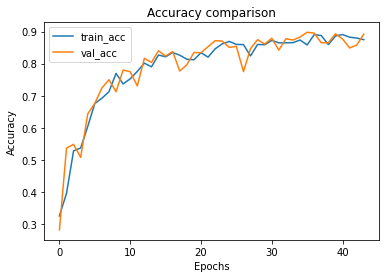

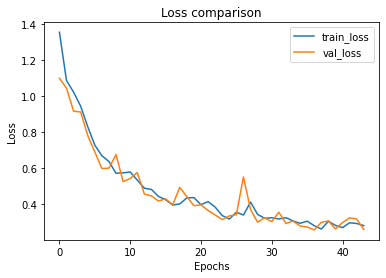

In [35]:
plt.plot(aug_history2.history['accuracy'], label='train_acc')
plt.plot(aug_history2.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title('Accuracy comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

plt.plot(aug_history2.history['loss'], label='train_loss')
plt.plot(aug_history2.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## Evaluate best model

### Fit best model on entire training data

In [29]:
model = tf.keras.models.load_model("checkpoint_path.keras")
final_model = model.fit(train_x,  train_y, verbose=2)

57/57 - 8s - loss: 0.2646 - accuracy: 0.8959 - 8s/epoch - 140ms/step


### Evaluate model on test set

In [31]:
model.evaluate(test_x,  test_y, verbose=2)

15/15 - 0s - loss: 0.2226 - accuracy: 0.9024 - 385ms/epoch - 26ms/step


[0.22264252603054047, 0.9024389982223511]